<a href="https://colab.research.google.com/github/Sulmon/Deep-Learning/blob/dev_branch/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Networks

In previous unit we have learned how to define a multi-layered neural network using the class definition, but those network were generic and not specialized. In this unit we will learn about CNNs, which are specifically designed for **Computer Vision**.

Computer vision is different from generic classification, because when we are trying to find a certain object in the picture, we are scanning the image looking for some specific **patterns** and their combinations. For example, when looking for a cat, we first may look for horizontal lines, which can form whiskers, and then certain combination of whiskers can tell us that it is actually a picture of a cat. Relative position and presence of certain patterns is important, and not their exact position on the image.


To extract patterns, we will use the notion of convolutional filters.

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2023-02-13 12:41:09--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.39K  --.-KB/s    in 0s      

2023-02-13 12:41:10 (51.7 MB/s) - ‘pytorchcv.py’ saved [6540/6540]



In [9]:
from torchvision.datasets.imagenet import load_meta_file
from pytorchcv import  load_mnist,train,plot_results,plot_convolution,display_dataset
load_mnist(batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [13]:
#Loading the necessary modules
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchinfo import summary
from torchvision.datasets import MNIST
import numpy as np 
from torchinfo import summary


***Convolutional filters*** are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.
They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:

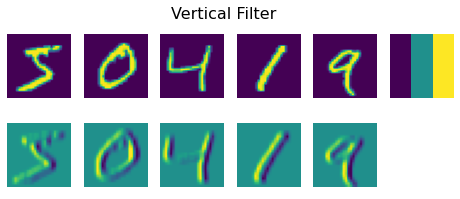

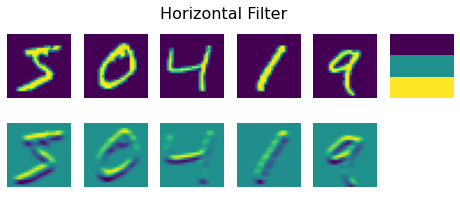

In [10]:
plot_convolution(torch.Tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical Filter')
plot_convolution(torch.Tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal Filter')

First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.
it is as if different filters are assign to identify different patterns
If we apply 3×3 filter to an image of size 28×28 the size of the image will become 26×26 , because the filter does not go over the image boundaries. In some cases, however, we may want to keep the size of the image the same, in which case image is padded with zeros on each side.


In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, **in deep learning we construct networks that learn best convolutional filters** to solve classification problem.

###**Convolutional layers**

Convolutional layers are defined using nn.Conv2d construction. We need to specify the following:
* **in_channels** -number of input channels. In our case we are dealing with a grayscale image, thus number of input channel is 1. Color image has 3 channels RGB
* **out_channels** -number of filters to use. We will use 9 different filters, which will give the network plenty of opportunity to explore which filter work best for our scenario.
* **kernel_size** it is the size of the sliding window *(shape of the filter matrix?)*. usually 3x3 or 5x5.The choice of the kernel_size is generally done empirically (with a heuristic).

Simplest CNN will contain one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24 (the spatial size is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels). Here the result of each filter is represented by a different channel in the image (thus the first dimension 9 corresponds to the number of filters).

After convolution, we flatten 9x24x24 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use `relu` activation function in between layers. 


In [27]:
#Convolutional Neural Network Definition with one convolution layer
class OneConv(nn.Module):
  def __init__(self):
    super(OneConv,self).__init__()
    self.conv = nn.Conv2d(in_channels=1, out_channels=9,kernel_size=(5,5))
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(5184,10)

  def forward(self,x):
    x = nn.functional.relu(self.conv(x))
    x = self.flatten(x)
    x = nn.functional.log_softmax(self.fc(x),dim=1)
    return x


In [29]:
net = OneConv()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalize much better.Note that the number of parameters of convolutional layer is quite small, and it does not depend on the resolution of the image! In our case, we were using 9 filters of dimension  5×5 , thus the number of parameters is 9×5×5+9=234
The convolutional filter also has bias (set to 9 in this case). Most of the parameters of our network comes from the final Dense layer.


Epoch  0, Train acc=0.941, Val acc=0.977, Train loss=0.002, Val loss=0.001
Epoch  1, Train acc=0.979, Val acc=0.979, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.986, Val acc=0.978, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.988, Val acc=0.978, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.989, Val acc=0.978, Train loss=0.000, Val loss=0.001


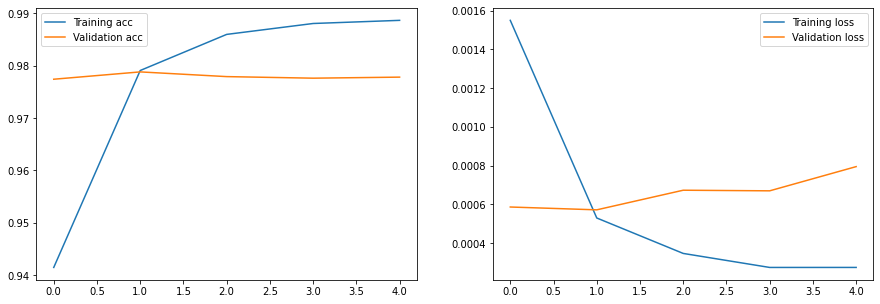

In [30]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

 we are able to achieve higher accuracy, and much faster, compared to the fully-connected networks from previous unit.We can also visualize the weights of our trained convolutional layers, to try and make some more sense of what is going on:

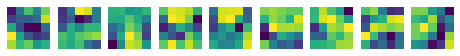

In [35]:
fig,ax = plt.subplots(1,9,figsize=(8,4))
with torch.no_grad():
  p = next(net.conv.parameters())
  for i,x in enumerate(p):
    ax[i].imshow(x.detach().cpu()[0,...])
    ax[i].axis('off')

###**Takeaway**

Convolutional layer allows us to extract certain image patterns from the image, so that final classifier is based on top of those features. However, we can use the same approach of extracting patterns inside the feature space, by stacking another convolutional layer on top of the first one. We will learn about multi-layer convolutional networks in the next unit.